# Chapter 4: Numerical Computation

In [2]:
import numpy as np
from numpy import linalg as LA
import tensorflow as tf

## 4.1 Overflow and Underflow

The fundamental difficulty in performing continuous math on a digital computer is that we need to represent infinitely many real numbers with a finite number of bit patters. This means that for almost all real numbers, we incur some approximation error when we represent the number in the computer.

One form of rounding error that is particularly devastating is **underflow**, which occurs when numbers near zero are rounded to zero. Many functions behave qualitatively differently when their argument is zero rather than a small positive number. For example, we usually want to avoid division by zero.

Another highly damaging form of numerical error is overflow. Overflow occurs when numbers with large magnitude are approximated as $\infty$ or $-\infty$. Further arthmetic will usually change these infinite values into not-a-number values.

One example for a function that must be stabilized against underflow and overflow is the **softmax function**. The softmax function is often used to predict the probabilities associated with a multinoulli distribution. 

The softmax function is defined to be $softmax(\boldsymbol{x})_{i} = \frac{exp(x_{i})}{\sum\limits_{j=1}^n exp(x_{j}}$.

Consider what happens when all the $x_{i}$ are equal to some constant $c$. Analytically, we can see that all the outputs should equal $\frac{1}{n}$. Numerically this may not occur when $c$ has large magnitude. 

If $c$ is very negative, then $exp(c)$ will underflow. This means the denominator of the softmax will become 0, so the final result is undefined.

If $c$ is very large and positive, $exp(c)$ will overflow, again resulting in the expression as a whole being undefined.

Both of these difficulties can be resulved by instead evaluating $softmax(\boldsymbol{z})$ where $\boldsymbol{z} = \boldsymbol{x} - max_{i}x_{i}$. Simple algebra shows that the value of the softmax function is not changed analytically by adding or subtracting a scalar from the input vector. Subtracting $max_{i}x_{i}$ results in the largest argument to $exp$ being 0, which rules out the possibility of overflow. Likewise, at least one term in the denominator has a value of 1, which rules out the possibility of underflow in the denominator leading to a division by zero.

There is still one small problem. Underflow in the numberator can still cause the expression as a while to evaluate to zero. This means that if we implement $log \: softmax(\boldsymbol{x})$ by first running the softmax subroutine then passing the result to a log function, we could accidently obtain $-\infty$. Instead, we must implement a a separate function that calculates log softmax in a numerically stable way. The log softmax function can be stabilized using the same trick as we used to stabilize the softmax function.

In [18]:
# passing a vector v through tf's softmax function
# all underflow/overflow issues are stabilized by tensorflow
v = tf.Variable([1., 2., 3., 4.], tf.float32, name="v") 
w = tf.nn.softmax(v, name="w")


model = tf.global_variables_initializer()  # initialize variables

with tf.Session() as session:  # create a session
    session.run(model)  # run model (tf.global_variables_initializer())
    print("A vector, v:", session.run(v), "\n")
    print("V passed through the softmax function:", session.run(w))

A vector, v: [ 1.  2.  3.  4.] 

V passed through the softmax function: [ 0.0320586   0.08714432  0.23688281  0.64391422]


## 4.2 Poor Conditioning

Conditioning refers to how rapidly a function changed iwth respect to small changes in its inputs. Functions that change rapidly when their inputs are perturbed slightly can be problematic for scientific computation because rounding errors in th inputs can result in large changes in the output.

Consider the function $f(\boldsymbol{x}) = \boldsymbol A^{-1}\boldsymbol{x}$ When $\boldsymbol{A} \in \mathbb{R}^{n\times n}$ has an eigenvalue decomposition, its condition number is $\max_{i, j} \lvert \frac{\lambda_{i}}{\lambda_{j}}\rvert$.

This is the ratio of the magnitude of the largest and smallest eigenvalue. When this number is large, matrix inversion is particularly sensitive to error in the input.

In [80]:
# get condition number of a matrix A with respect to the eigenvalues of A
# remark: the cond function for computing the cond number of a matrix found in numpy.linalg computes w respect to svd
A = np.array([[8, 6, 4, 1], [1, 4, 5, 1], [8, 4, 1, 1], [1, 4, 3, 6]])
w, v = LA.eig(A) # w: eigenvalues, v: eigenvectors
cond = abs(max(w)/min(w))
cond

12.079482324306841

In [86]:
# get condition number of a matrix B with respect to the eigenvalues of A
B = np.array([[1, 0, -1], [0, 1, 1], [-1, 1, 0]])
w, v = LA.eig(B) # w: eigenvalues, v: eigenvectors
cond = abs(max(w)/min(w))
cond

2.0

## 4.2 Gradient-Based Optimization

Most deep learning algoriths involve optimization of some sort. Optimization refers to the task of either minimizing or maximizing some function $f(\boldsymbol{x})$ by altering $\boldsymbol{x}$. We usually phrase most optimization problems in terms of minimizing $f(\boldsymbol{x})$. Maximization may be accomplished via a minimization algorithm my minimizing $-f(\boldsymbol{x})$.

The function we want to minimize or maximize is called the **objective function**, or **criterion**. When we are minimizing it, we may also call it the **cost function**, **loss function** or **error function**. In this book, we use these terms interchangeably.

We often denote the value that minimizes or maximizes a function with a superscript $*$. For example, we might say that $\boldsymbol{x}^{*} = argmin \: f(\boldsymbol{x})$.

Suppose we have a function y=f(x), where both $x$ and $y$ are real numbers. The **derivative** of this function is denoted as $f'(x)$ or as $\frac{dy}{dx}$. The derivative $f'(x)$ gives the slope of f(x) at the point $x$. In other words, it specifies how to scale a small change in the input to obtain the corresponding change in the output: $f(x+\epsilon)\approx f(x) + \epsilon f'(x)$.

The derivative is therefore useful for minimizing a function because it tells us how to change $x$ in order to make a small improvement in $y$. For example, we know that $f(x - \epsilon sign(f'(x)))$ is less than $f(x)$ for small enough $\epsilon$. This technique is called **gradient descent**.

We often minimize functions that have multiple inputs:  $ \: f: \mathbb{R}^n \rightarrow \mathbb{R}$. For the concept of "minimization" to make sense, there must still be only one (scalar) output.

For functions with multiple inputs, we must make use of the concept of **partial derivatives**. The partial derivative $\frac{\partial}{\partial_{x_{i}}}f(\boldsymbol{x})$ measures how $f$ changes as only the variable $x_{i}$ increases at the point $\boldsymbol{x}$. The **gradient** generalizes the notion of derivative to the case where the derivative is with respect to a vector: the gradient of $f$ is the vector containing all the partial derivatives, denoted $\nabla_{x}f(\boldsymbol{x})$. Element $i$ of the gradient is the partial derivative of f with respect to $x_i$. In multiple dimensions, **critical points** are where every element of the gradient is equal to zero.

In [39]:
# calculate the gradient of the function f(x) = x*sin(x) with respect to v
v = tf.Variable([1., 2., 4., 7., 11., 16.], tf.float32, name="v")
w = tf.sin(v, name="w")
f = tf.multiply(v, w, name="f")

grad = tf.gradients(f, v)[0]

model = tf.global_variables_initializer()  # initialize variables

with tf.Session() as session:  # create a session
    session.run(model)  # run model (tf.global_variables_initializer())
    print("A vector, v:", session.run(v), "\n")
    print("The gradient of f: x*sin(x) with respect to v: \n\n", session.run(grad))

A vector, v: [  1.   2.   4.   7.  11.  16.] 

The gradient of f: x*sin(x) with respect to v: 

 [  1.38177323   0.07700378  -3.37137699   5.93430233  -0.95130754
 -15.61045456]


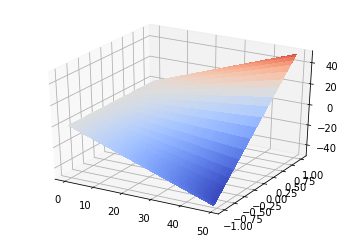

In [51]:
# plot the function f(x) = x*sin(x)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

x = np.array([i for i in range(50)])
y = np.sin(x)
x, y = np.meshgrid(x, y)
z = np.multiply(x, y)

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title("f(x) = x*sin(x)")
plt.show()

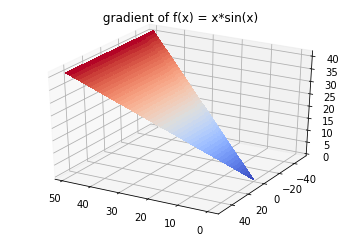

In [69]:
# plot the gradient
fig = plt.figure()
ax = fig.gca(projection='3d')

grad = np.gradient(z)[0][0]

surf = ax.plot_surface(x, z, grad, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 120)

plt.title(" gradient of f(x) = x*sin(x)")
plt.show()

The **directional derivative** in direction $\boldsymbol{u}$ (a unit vector) is the flope of the function $f$ int he direction $u$. In other words, the directional derivative is the derivative of the function $f(\boldsymbol{x}+\alpha \boldsymbol{u})$ with respect to $\alpha$, evaluated at $\alpha = 0$.

To minimize $f$, we would like to find the firection in which $f$ decreases the fastest. We can do this using the directional derivative:

$ \quad min_{u, u^{\top}u=1} \boldsymbol{u}^\top \nabla_{x}f(\boldsymbol{x})$

## Example: Linear Least Squares

Suppose we want to find the value of **x** that minimizes $f(x) = \frac{1}{2} \| \bf{Ax-b} \|^2_{2}$.

Specialized linear algebra algorithms can solve this problem efficiently; however we can also explore how to solve it using gradient-based optimization as a simple example of how these techniques work.

First we need to obtain the gradient:

$\nabla_{x}f(x) = \bf A^\top(Ax-b) = A^\top Ax - A^\top b.$

We can then follow this gradient downhill, taking small steps. See algorithm 4.1 for more details.

### Algorithm 4.1

An algorithm to minimize $f(x) = \frac{1}{2} \| \bf{Ax-b} \|^2_{2}$ with respect to **x** using gradient descent, starting from an arbitrary value of **x**:


Set the step size $(\epsilon)$ and tolerance $(\delta)$ to small, positive numbers.  
**while** $ f(x) = \| A^\top Ax - A^\top b|_{2} > \it \delta $ **do**  
&nbsp;&nbsp;&nbsp;&nbsp; $\bf{x} \leftarrow x - \epsilon(A^\top Ax - A^\top b)$  
**end while**
 

In [24]:
A = np.array([[8, 6, 4, 1], [1, 4, 5, 1], [8, 4, 1, 1], [1, 4, 3, 6]])
b1 = np.array([19, 11, 14, 14])
b2 = np.array([19.01, 11.05, 14.07, 14.05])